In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
#import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.transforms import CenterCrop
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from torch.nn import Parameter
# torch.manual_seed(42)
# np.random.seed(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


In [ ]:
INPUT_IMAGE_HEIGHT = 240 #352 in original paper
INPUT_IMAGE_WIDTH = 240
BATCH_SIZE = 8
# IMAGE_DATASET_PATH = '/content/gdrive/MyDrive/Phd work/UNet++/Image/'
# MASK_DATASET_PATH = '/content/gdrive/MyDrive/Phd work/UNet++/Mask/'
IMAGE_DATASET_PATH = '/content/gdrive/MyDrive/Phd work/ISIC 2017/ISIC_2017/'
MASK_DATASET_PATH = '/content/gdrive/MyDrive/Phd work/ISIC 2017/ISIC-2017_Training_Part1_GroundTruth/'

seed = np.random.randint(2147483647)
np.random.seed(seed)
torch.manual_seed(seed)
TEST_SPLIT = 0.30
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:
# load the image and mask filepaths in a sorted manner

imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

trainImages, testImages, trainMasks, testMasks = train_test_split(imagePaths, maskPaths,test_size=TEST_SPLIT, random_state=42)
len(trainImages), len(testImages), len(trainMasks), len(testMasks)

(1400, 600, 1400, 600)

In [ ]:
# # import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [ ]:
# # define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size= BATCH_SIZE, num_workers=os.cpu_count()) #pin_memory= PIN_MEMORY
testLoader = DataLoader(testDS, shuffle=False, batch_size= BATCH_SIZE, num_workers=os.cpu_count())

[INFO] found 1400 examples in the training set...
[INFO] found 600 examples in the test set...


Shape of the inputs tensor: torch.Size([8, 3, 240, 240])
Shape of the masks tensor: torch.Size([8, 1, 240, 240])


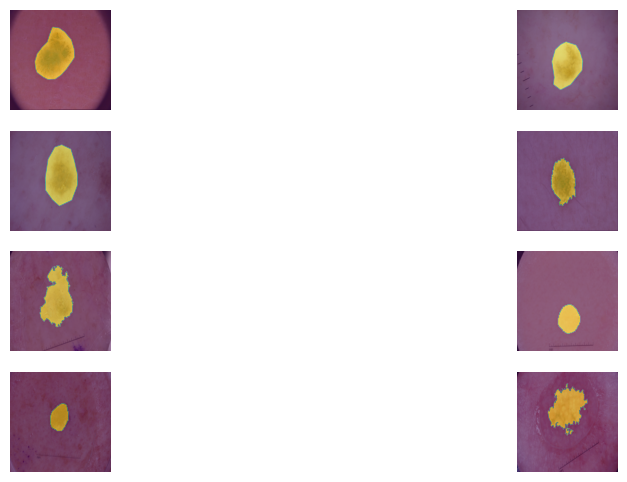

In [ ]:
# # import matplotlib.pyplot as plt

# # obtain a batch of training data
inputs, masks = next(iter(trainLoader))

print("Shape of the inputs tensor:", inputs.shape)
print("Shape of the masks tensor:", masks.shape)

# plot the images and masks from the batch
fig, axs = plt.subplots(4, 2, figsize=(12, 6))
for i in range(4):
    for j in range(2):
        idx = i*2+j
        # extract the image and mask tensors from the batch
        img_tensor = inputs[idx]
        mask_tensor = masks[idx]
        # convert the tensors to numpy arrays and transpose the dimensions
        img = img_tensor.permute(1, 2, 0).numpy()
        mask = mask_tensor.squeeze().numpy()
        # plot the image and mask side-by-side
        axs[i, j].imshow(img)
        axs[i, j].imshow(mask,alpha = 0.5)
        axs[i, j].axis('off')
plt.show()

In [ ]:
# #For augmentation
# from torch.utils.data import Dataset
# import cv2
# from torchvision.transforms import functional as TF
# from PIL import Image
# from torchvision.transforms import RandomAffine, RandomHorizontalFlip, RandomVerticalFlip
# import numpy as np


# class SegmentationDataset(Dataset):
#     def __init__(self, imagePaths, maskPaths, transforms=None):
#         # store the image and mask filepaths, and augmentation transforms
#         self.imagePaths = imagePaths
#         self.maskPaths = maskPaths
#         self.transforms = transforms

#     def __len__(self):
#         # return the number of total samples contained in the dataset
#         return len(self.imagePaths)

#     def __getitem__(self, idx):
#         # grab the image path from the current index
#         imagePath = self.imagePaths[idx]
#         # load the image from disk, swap its channels from BGR to RGB,
#         # and read the associated mask from disk in grayscale mode
#         image = cv2.imread(imagePath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.maskPaths[idx], 0)

#         # check to see if we are applying any transformations
#         if self.transforms:
#             sample = {'image': Image.fromarray(image), 'mask': Image.fromarray(mask)}
#             sample = self.transforms(sample)
#             image = TF.to_tensor(sample['image'])
#             mask = TF.to_tensor(sample['mask'])

#             # Ensure that the image and mask tensors have the same size
#             assert image.shape[1:] == mask.shape[1:], "Image and mask tensors do not have the same size"


#         # return a tuple of the image and its mask
#         return (image, mask)

# class SegmentationTransforms:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, sample):
#         image, mask = sample['image'], sample['mask']
#         seed = np.random.randint(2147483647)  # get a random seed
#         for t in self.transforms:
#             if isinstance(t, (RandomAffine, RandomHorizontalFlip, RandomVerticalFlip)):
#                 # Apply the same transformation to both image and mask using a fixed seed
#                 np.random.seed(seed)
#                 torch.manual_seed(seed)
#                 image = t(image)
#                 np.random.seed(seed)
#                 torch.manual_seed(seed)
#                 mask = t(mask)
#             else:
#                 image, mask = t(image, mask)
#         return {'image': image, 'mask': mask}


# class ResizeTransform:
#     def __init__(self, size):
#         self.size = size

#     def __call__(self, image, mask):
#         image = TF.resize(image, self.size)
#         mask = TF.resize(mask, self.size, interpolation=Image.BILINEAR)
#         return image, mask

# class RandomZoom:
#     def __init__(self, scale=(0.9, 1.1)):
#         self.scale = scale

#     def __call__(self, image, mask):
#         scale_factor = np.random.uniform(self.scale[0], self.scale[1])
#         width, height = image.size
#         new_width, new_height = int(width * scale_factor), int(height * scale_factor)
#         image = TF.resize(image, (new_height, new_width))
#         mask = TF.resize(mask, (new_height, new_width), interpolation=Image.BILINEAR)
#         return image, mask

# # Define the transformations for training set
# train_transforms = SegmentationTransforms([
#     RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Rotation and Shift
#     RandomZoom(),  # Zoom
#     RandomHorizontalFlip(p=0.5),  # Horizontal Flip
#     RandomVerticalFlip(p=0.5),    # Vertical Flip
#     ResizeTransform((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH))  # Ensure consistent size
# ])

# # Define the transformations for test set (only resizing)
# test_transforms = SegmentationTransforms([
#     ResizeTransform((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH))
# ])

# # create the train and test datasets
# trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=train_transforms)
# testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=test_transforms)

# print(f"[INFO] found {len(trainDS)} examples in the training set...")
# print(f"[INFO] found {len(testDS)} examples in the test set...")

# # create the training and test data loaders
# trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
# testLoader = DataLoader(testDS, shuffle=False, batch_size=BATCH_SIZE, num_workers=os.cpu_count())




[INFO] found 533 examples in the training set...
[INFO] found 95 examples in the test set...


Dimension of Image:  torch.Size([8, 3, 240, 240])
Dimaension of Mask:  torch.Size([8, 1, 240, 240])


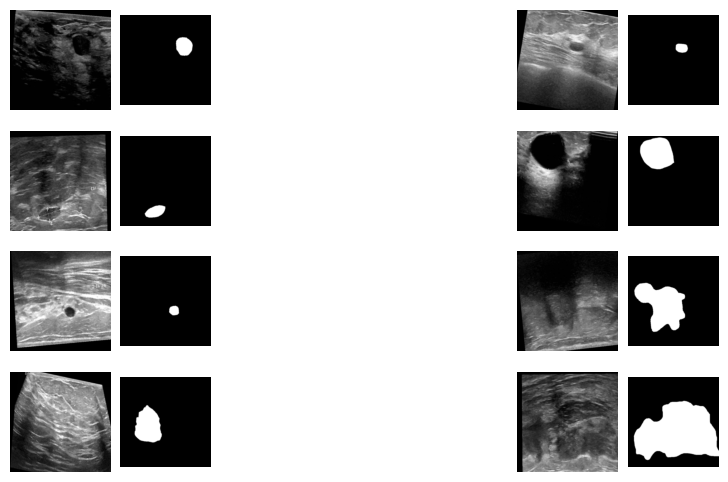

In [ ]:
# import matplotlib.pyplot as plt

# # obtain a batch of training data
# inputs, masks = next(iter(trainLoader))

# print("Dimension of Image: ", inputs.shape)
# print("Dimaension of Mask: ", masks.shape)

# # plot the images and masks from the batch
# fig, axs = plt.subplots(4, 2, figsize=(12, 6))
# for i in range(4):
#     for j in range(2):
#         idx = i*2+j
#         # extract the image and mask tensors from the batch
#         img_tensor = inputs[idx]
#         mask_tensor = masks[idx]
#         # convert the tensors to numpy arrays and transpose the dimensions
#         img = img_tensor.permute(1, 2, 0).numpy()
#         mask = mask_tensor.squeeze().numpy()
#         # plot the image and mask side-by-side
#         axs[i, j].imshow(img)
#         axs[i, j].axis('off')

#         # create a new subplot for the mask
#         axs2 = axs[i, j].inset_axes([1.1, 0, 0.9, 1])
#         axs2.imshow(mask, cmap='gray')
#         axs2.axis('off')

# # plt.show()

In [ ]:
class AFF(nn.Module):


    def __init__(self, channels, r=4):
        super(AFF, self).__init__()
        inter_channels = int(channels // r)

        self.local_att = nn.Sequential(
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )

        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )

        self.sigmoid = nn.Sigmoid()


    def forward(self, x, outI, feature_Level):
        xa = x + outI + feature_Level # x = I_out4, outI = x5,  feature_Level = x4
        #print("Inside AFF xa: ", xa.size())
        xl = self.local_att(xa)
        #print("Inside AFF xl: ", xl.size())
        xg = self.global_att(xa)
        #print("Inside AFF xg: ", xg.size())
        xlg = xl + xg
        #print("Inside AFF xlg: ", xlg.size())
        wei = self.sigmoid(xlg)

        xo = 2 * x * wei + 2 * outI * (1 - wei)
        #print("Inside AFF xo: ", wei.size())
        return xo


In [ ]:
##### Our model #####
import torch
import torch.nn as nn
#import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, AFF_channel, bilinear=False):
    #def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        self.aff= AFF(AFF_channel)

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels) #AFF

        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            #self.conv = DoubleConv(in_channels//2, out_channels, in_channels // 4)
            self.conv = DoubleConv(in_channels//2, out_channels)



    def forward(self, x1, x2, x3):
        #print("inside forward up( initial call) x1 and x2: ", x1.size(),x2.size())
        x1 = self.up(x1) # during first call x1 = x5, x2 = x4
        #x = self.model1(x2,x1,x3)

        x = self.aff(x2,x1,x3)

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
       return self.conv(x)


In [ ]:
##### Our model #####
class UNetAFF(nn.Module):

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetAFF, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.spatial_avgpool = nn.AdaptiveAvgPool2d(1)
        #channel_maxpool = torch.max(FRi, dim=1, keepdim=True)[0]

        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            #nn.Sigmoid(),
            nn.ReLU(inplace=True),
           )

        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            #nn.Sigmoid(),
            nn.ReLU(inplace=True),
           )

        self.trans_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            #nn.Sigmoid(),
            nn.ReLU(inplace=True),
           )

        self.trans_conv3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            #nn.Sigmoid(),
            nn.ReLU(inplace=True),
           )

        self.trans_conv4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)

        """ No change in Unet network (used for MS_CAM) & (AFF then cat)"""

        """ For AFF and iAFF"""
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        #factor = 2 if bilinear else 1
        factor = 2
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512 , 512)
        self.up2 = Up(512, 256, 256)
        self.up3 = Up(256, 128 , 128)
        self.up4 = Up(128, 64, 64)
        self.outc = OutConv(64, n_classes)
        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.inc(x)
        s1 = self.spatial_avgpool(x1)
        #c1 = torch.max(x1, dim=1, keepdim=True)[0]
        c1 = torch.mean(x1, dim=1, keepdim=True)
        mul1 = s1 * c1
        #print("Inside UNET Forward: mul1 = ", mul1.size())
        x2 = self.down1(x1)
        s2 = self.spatial_avgpool(x2)
        #c2 = torch.max(x2, dim=1, keepdim=True)[0]
        c2 = torch.mean(x2, dim=1, keepdim=True)
        mul2 = s2 * c2
        #print("Inside UNET Forward: mul2  = ", mul2.size())
        Trans_conv1 = self.trans_conv1(mul2)
        I_out_1 = self.conv1(mul1 + Trans_conv1)
        I_out_1 = I_out_1 * x1
        #print("Inside UNET Forward: I_out_1 = ", I_out_1.size())
        x3 = self.down2(x2)
        s3 = self.spatial_avgpool(x3)
        #c3 = torch.max(x3, dim=1, keepdim=True)[0]
        c3 = torch.mean(x3, dim=1, keepdim=True)
        mul3 = s3 * c3
        #print("Inside UNET Forward: mul3  = ", mul3.size())
        Trans_conv2 = self.trans_conv2(mul3)
        I_out_2 = self.conv2(mul2 + Trans_conv2)
        I_out_2 =  I_out_2 * x2
        #print("Inside UNET Forward: I_out_2 = ", I_out_2.size())
        x4 = self.down3(x3)
        #print("Inside UNET Forward: X4 = ", x4.size())
        s4 = self.spatial_avgpool(x4)
        #c4 = torch.max(x4, dim=1, keepdim=True)[0]
        c4 = torch.mean(x4, dim=1, keepdim=True)
        mul4 = s4 * c4
        #print("Inside UNET Forward: mul4  = ", mul4.size())
        Trans_conv3 = self.trans_conv3(mul4)
        #print("Inside UNET Forward: Trans_conv3  = ", Trans_conv3.size())
        I_out_3 = self.conv3(mul3 + Trans_conv3)
        I_out_3 =  I_out_3 * x3
        #print("Inside UNET Forward: I_out_3 = ", I_out_3.size())
        x5 = self.down4(x4)
        #print("Inside UNET Forward: X5 = ", x5.size())
        s5 = self.spatial_avgpool(x5)
        #c5 = torch.max(x5, dim=1, keepdim=True)[0]
        c5 = torch.mean(x5, dim=1, keepdim=True)
        mul5 = s5 * c5
        #print("Inside UNET Forward: mul5  = ", mul5.size())
        Trans_conv4 = self.trans_conv4(mul5)
        I_out_4 = self.conv4(mul4 + Trans_conv4)
        I_out_4 = I_out_4 * x4
        #print("Inside UNET Forward: I_out_4 = ", I_out_4.size())
        # for model1 2 input
        x = self.up1(x5, I_out_4, x4)

        #print("x after up1: up1(x5, x4) = ", x.size())
        x = self.up2(x, I_out_3, x3)

        #print("x: up2(x, x3) = ", x.size())
        x = self.up3(x, I_out_2, x2)

        #print("x: up3(x, x2) = ", x.size())
        x = self.up4(x, I_out_1, x1)

        #print("x: up4(x, x1) = ", x.size())
        logits = self.outc(x)
        #print("outc(x) = ", logits.size())
        return logits


In [ ]:
def one_hot_embedding(labels, num_classes=3,device=None):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes,device=device)
    return y[labels]

In [ ]:
import torch
import torch.nn.functional as F

def relu_evidence(y):
    return F.relu(y)


def exp_evidence(y):
    return torch.exp(torch.clamp(y, -10, 10))


def softplus_evidence(y):
    return F.softplus(y)


def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl


def loglikelihood_loss(y, alpha, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var
    return loglikelihood


def mse_loss(y, alpha, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    loglikelihood = loglikelihood_loss(y, alpha, device=device)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return loglikelihood + kl_div


def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div


def edl_mse_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        mse_loss(target, alpha, epoch_num, num_classes, annealing_step, device=device)
    )
    return loss


def edl_log_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.log, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


In [ ]:
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
criterion = BCEWithLogitsLoss()
NUM_EPOCHS = 80
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

In [ ]:
def evaluation_metrices(output, target):
  smooth = 1e-5

  if torch.is_tensor(output):
    output = torch.sigmoid(output).data.cpu().numpy()
  if torch.is_tensor(target):
    target = target.data.cpu().numpy()

    output_ = output > 0.5
    target_ = target > 0.5

    true_positives = (output_ & target_).sum()
    false_positives = (output_ & ~target_).sum()
    false_negatives = (~output_ & target_).sum()
    true_negatives = (~output_ & ~target_).sum()

    sensitivity = (true_positives ) #/ (true_positives + false_negatives )
    specificity = (true_negatives) #/ (true_negatives + false_positives )
    accuracy = (true_positives + true_negatives ) #/ (true_positives + true_negatives + false_positives + false_negatives )


    intersection = true_positives
    union = true_positives + false_positives + false_negatives

    iou = intersection  #/ (union + smooth)
    dice = 2 * intersection  #/ (union + intersection + smooth)

    #iou = (intersection + smooth) / (union + smooth)
    #dice = (2 * intersection + smooth) / (union + intersection + smooth)

    return iou, dice, accuracy, sensitivity, specificity, true_positives, false_positives, false_negatives, true_negatives




moving models to GPU ...
done

[INFO] training the network...


  0%|          | 0/80 [00:00<?, ?it/s]

[INFO] EPOCH: 1/80
Train loss: 0.9972, Val loss: 0.7864, Train_iou: 0.5739, Val_iou: 0.6972
Dice Score: 0.8216, Accuracy: 0.9398, Sensitivity: 0.7526, Specificity: 0.9821


  1%|▏         | 1/80 [04:54<6:27:40, 294.43s/it]

saved best model based on IOU:  0.6972401043463891
[INFO] EPOCH: 2/80
Train loss: 0.7640, Val loss: 0.6564, Train_iou: 0.6798, Val_iou: 0.7110
Dice Score: 0.8311, Accuracy: 0.9447, Sensitivity: 0.7385, Specificity: 0.9913


  2%|▎         | 2/80 [07:23<4:31:17, 208.68s/it]

saved best model based on IOU:  0.7110039712336887
[INFO] EPOCH: 3/80
Train loss: 0.6747, Val loss: 0.5695, Train_iou: 0.6920, Val_iou: 0.7614
Dice Score: 0.8645, Accuracy: 0.9533, Sensitivity: 0.8091, Specificity: 0.9859


  4%|▍         | 3/80 [09:51<3:52:19, 181.03s/it]

saved best model based on IOU:  0.7613987500773942


  5%|▌         | 4/80 [12:17<3:31:41, 167.13s/it]

[INFO] EPOCH: 4/80
Train loss: 0.6132, Val loss: 0.5506, Train_iou: 0.7028, Val_iou: 0.7368
Dice Score: 0.8484, Accuracy: 0.9477, Sensitivity: 0.7948, Specificity: 0.9822
EarlyStopping counter: 1 out of 20


  6%|▋         | 5/80 [14:43<3:19:35, 159.67s/it]

[INFO] EPOCH: 5/80
Train loss: 0.5589, Val loss: 0.5128, Train_iou: 0.7209, Val_iou: 0.7490
Dice Score: 0.8565, Accuracy: 0.9499, Sensitivity: 0.8111, Specificity: 0.9813
EarlyStopping counter: 2 out of 20


  8%|▊         | 6/80 [17:09<3:11:14, 155.06s/it]

[INFO] EPOCH: 6/80
Train loss: 0.5278, Val loss: 0.4732, Train_iou: 0.7214, Val_iou: 0.7433
Dice Score: 0.8528, Accuracy: 0.9510, Sensitivity: 0.7693, Specificity: 0.9921
EarlyStopping counter: 3 out of 20


  9%|▉         | 7/80 [19:34<3:04:39, 151.77s/it]

[INFO] EPOCH: 7/80
Train loss: 0.4879, Val loss: 0.4439, Train_iou: 0.7470, Val_iou: 0.7591
Dice Score: 0.8631, Accuracy: 0.9526, Sensitivity: 0.8107, Specificity: 0.9847
EarlyStopping counter: 4 out of 20


 10%|█         | 8/80 [21:59<2:59:31, 149.61s/it]

[INFO] EPOCH: 8/80
Train loss: 0.4776, Val loss: 0.4364, Train_iou: 0.7370, Val_iou: 0.7380
Dice Score: 0.8492, Accuracy: 0.9503, Sensitivity: 0.7595, Specificity: 0.9934
EarlyStopping counter: 5 out of 20
[INFO] EPOCH: 9/80
Train loss: 0.4537, Val loss: 0.4011, Train_iou: 0.7497, Val_iou: 0.7678
Dice Score: 0.8687, Accuracy: 0.9553, Sensitivity: 0.8014, Specificity: 0.9901


 11%|█▏        | 9/80 [24:26<2:56:10, 148.87s/it]

saved best model based on IOU:  0.7678101002126525
[INFO] EPOCH: 10/80
Train loss: 0.4291, Val loss: 0.3822, Train_iou: 0.7643, Val_iou: 0.7874
Dice Score: 0.8810, Accuracy: 0.9590, Sensitivity: 0.8239, Specificity: 0.9895


 12%|█▎        | 10/80 [26:53<2:52:58, 148.26s/it]

saved best model based on IOU:  0.7873679171955981
[INFO] EPOCH: 11/80
Train loss: 0.3972, Val loss: 0.3634, Train_iou: 0.7857, Val_iou: 0.8064
Dice Score: 0.8929, Accuracy: 0.9624, Sensitivity: 0.8491, Specificity: 0.9880


 14%|█▍        | 11/80 [29:20<2:49:52, 147.71s/it]

saved best model based on IOU:  0.8064433053490461


 15%|█▌        | 12/80 [31:44<2:46:11, 146.65s/it]

[INFO] EPOCH: 12/80
Train loss: 0.3878, Val loss: 0.3685, Train_iou: 0.7904, Val_iou: 0.7843
Dice Score: 0.8791, Accuracy: 0.9593, Sensitivity: 0.8028, Specificity: 0.9947
EarlyStopping counter: 1 out of 20


 16%|█▋        | 13/80 [34:10<2:43:32, 146.46s/it]

[INFO] EPOCH: 13/80
Train loss: 0.3815, Val loss: 0.3640, Train_iou: 0.7934, Val_iou: 0.7871
Dice Score: 0.8809, Accuracy: 0.9597, Sensitivity: 0.8075, Specificity: 0.9941
EarlyStopping counter: 2 out of 20


 18%|█▊        | 14/80 [36:36<2:41:04, 146.43s/it]

[INFO] EPOCH: 14/80
Train loss: 0.3698, Val loss: 0.3483, Train_iou: 0.8004, Val_iou: 0.8027
Dice Score: 0.8905, Accuracy: 0.9621, Sensitivity: 0.8371, Specificity: 0.9903
EarlyStopping counter: 3 out of 20
[INFO] EPOCH: 15/80
Train loss: 0.3581, Val loss: 0.3357, Train_iou: 0.8041, Val_iou: 0.8092
Dice Score: 0.8945, Accuracy: 0.9636, Sensitivity: 0.8386, Specificity: 0.9918


 19%|█▉        | 15/80 [39:03<2:38:52, 146.65s/it]

saved best model based on IOU:  0.8092150527973353


 20%|██        | 16/80 [41:31<2:36:50, 147.04s/it]

[INFO] EPOCH: 16/80
Train loss: 0.3468, Val loss: 0.3383, Train_iou: 0.8143, Val_iou: 0.7997
Dice Score: 0.8887, Accuracy: 0.9616, Sensitivity: 0.8316, Specificity: 0.9910
EarlyStopping counter: 1 out of 20


 21%|██▏       | 17/80 [43:57<2:34:02, 146.71s/it]

[INFO] EPOCH: 17/80
Train loss: 0.3370, Val loss: 0.3323, Train_iou: 0.8160, Val_iou: 0.8018
Dice Score: 0.8900, Accuracy: 0.9624, Sensitivity: 0.8260, Specificity: 0.9932
EarlyStopping counter: 2 out of 20


 22%|██▎       | 18/80 [46:23<2:31:23, 146.51s/it]

[INFO] EPOCH: 18/80
Train loss: 0.3348, Val loss: 0.3378, Train_iou: 0.8147, Val_iou: 0.7982
Dice Score: 0.8878, Accuracy: 0.9616, Sensitivity: 0.8241, Specificity: 0.9927
EarlyStopping counter: 3 out of 20


 24%|██▍       | 19/80 [48:49<2:28:47, 146.36s/it]

[INFO] EPOCH: 19/80
Train loss: 0.3309, Val loss: 0.3341, Train_iou: 0.8169, Val_iou: 0.7927
Dice Score: 0.8844, Accuracy: 0.9608, Sensitivity: 0.8140, Specificity: 0.9939
EarlyStopping counter: 4 out of 20
[INFO] EPOCH: 20/80
Train loss: 0.3237, Val loss: 0.3107, Train_iou: 0.8197, Val_iou: 0.8155
Dice Score: 0.8984, Accuracy: 0.9647, Sensitivity: 0.8458, Specificity: 0.9916


 25%|██▌       | 20/80 [51:16<2:26:21, 146.37s/it]

saved best model based on IOU:  0.8154978974447171
[INFO] EPOCH: 21/80
Train loss: 0.3039, Val loss: 0.3007, Train_iou: 0.8366, Val_iou: 0.8216
Dice Score: 0.9021, Accuracy: 0.9659, Sensitivity: 0.8518, Specificity: 0.9917


 26%|██▋       | 21/80 [53:43<2:24:05, 146.53s/it]

saved best model based on IOU:  0.8216473557642426


 28%|██▊       | 22/80 [56:09<2:21:34, 146.46s/it]

[INFO] EPOCH: 22/80
Train loss: 0.3008, Val loss: 0.3072, Train_iou: 0.8382, Val_iou: 0.8121
Dice Score: 0.8963, Accuracy: 0.9640, Sensitivity: 0.8441, Specificity: 0.9911
EarlyStopping counter: 1 out of 20


 29%|██▉       | 23/80 [58:34<2:18:50, 146.14s/it]

[INFO] EPOCH: 23/80
Train loss: 0.2966, Val loss: 0.3052, Train_iou: 0.8403, Val_iou: 0.8144
Dice Score: 0.8977, Accuracy: 0.9645, Sensitivity: 0.8459, Specificity: 0.9912
EarlyStopping counter: 2 out of 20


 30%|███       | 24/80 [1:01:00<2:16:12, 145.94s/it]

[INFO] EPOCH: 24/80
Train loss: 0.2916, Val loss: 0.3023, Train_iou: 0.8421, Val_iou: 0.8110
Dice Score: 0.8956, Accuracy: 0.9642, Sensitivity: 0.8331, Specificity: 0.9939
EarlyStopping counter: 3 out of 20
[INFO] EPOCH: 25/80
Train loss: 0.2842, Val loss: 0.2945, Train_iou: 0.8484, Val_iou: 0.8345
Dice Score: 0.9098, Accuracy: 0.9680, Sensitivity: 0.8749, Specificity: 0.9891


 31%|███▏      | 25/80 [1:03:27<2:14:04, 146.27s/it]

saved best model based on IOU:  0.8344694865070891


 32%|███▎      | 26/80 [1:05:52<2:11:27, 146.06s/it]

[INFO] EPOCH: 26/80
Train loss: 0.2864, Val loss: 0.3016, Train_iou: 0.8445, Val_iou: 0.8114
Dice Score: 0.8959, Accuracy: 0.9645, Sensitivity: 0.8290, Specificity: 0.9951
EarlyStopping counter: 1 out of 20


 34%|███▍      | 27/80 [1:08:18<2:08:57, 146.00s/it]

[INFO] EPOCH: 27/80
Train loss: 0.2791, Val loss: 0.2967, Train_iou: 0.8502, Val_iou: 0.8186
Dice Score: 0.9002, Accuracy: 0.9653, Sensitivity: 0.8490, Specificity: 0.9916
EarlyStopping counter: 2 out of 20


 35%|███▌      | 28/80 [1:10:43<2:06:13, 145.65s/it]

[INFO] EPOCH: 28/80
Train loss: 0.2771, Val loss: 0.2920, Train_iou: 0.8517, Val_iou: 0.8208
Dice Score: 0.9016, Accuracy: 0.9660, Sensitivity: 0.8456, Specificity: 0.9932
EarlyStopping counter: 3 out of 20


 36%|███▋      | 29/80 [1:13:09<2:03:58, 145.86s/it]

[INFO] EPOCH: 29/80
Train loss: 0.2709, Val loss: 0.2945, Train_iou: 0.8542, Val_iou: 0.8217
Dice Score: 0.9021, Accuracy: 0.9656, Sensitivity: 0.8593, Specificity: 0.9897
EarlyStopping counter: 4 out of 20


 38%|███▊      | 30/80 [1:15:37<2:01:50, 146.21s/it]

[INFO] EPOCH: 30/80
Train loss: 0.2706, Val loss: 0.2889, Train_iou: 0.8521, Val_iou: 0.8262
Dice Score: 0.9048, Accuracy: 0.9666, Sensitivity: 0.8608, Specificity: 0.9906
EarlyStopping counter: 5 out of 20


 39%|███▉      | 31/80 [1:18:02<1:59:16, 146.06s/it]

[INFO] EPOCH: 31/80
Train loss: 0.2606, Val loss: 0.2800, Train_iou: 0.8605, Val_iou: 0.8340
Dice Score: 0.9095, Accuracy: 0.9680, Sensitivity: 0.8730, Specificity: 0.9894
EarlyStopping counter: 6 out of 20


 40%|████      | 32/80 [1:20:28<1:56:51, 146.06s/it]

[INFO] EPOCH: 32/80
Train loss: 0.2557, Val loss: 0.2854, Train_iou: 0.8650, Val_iou: 0.8208
Dice Score: 0.9016, Accuracy: 0.9660, Sensitivity: 0.8458, Specificity: 0.9931
EarlyStopping counter: 7 out of 20


 41%|████▏     | 33/80 [1:22:55<1:54:32, 146.22s/it]

[INFO] EPOCH: 33/80
Train loss: 0.2544, Val loss: 0.2831, Train_iou: 0.8658, Val_iou: 0.8229
Dice Score: 0.9028, Accuracy: 0.9660, Sensitivity: 0.8577, Specificity: 0.9904
EarlyStopping counter: 8 out of 20


 42%|████▎     | 34/80 [1:25:21<1:52:02, 146.14s/it]

[INFO] EPOCH: 34/80
Train loss: 0.2490, Val loss: 0.2855, Train_iou: 0.8691, Val_iou: 0.8142
Dice Score: 0.8976, Accuracy: 0.9646, Sensitivity: 0.8416, Specificity: 0.9924
EarlyStopping counter: 9 out of 20


 44%|████▍     | 35/80 [1:27:48<1:49:47, 146.39s/it]

[INFO] EPOCH: 35/80
Train loss: 0.2509, Val loss: 0.2848, Train_iou: 0.8672, Val_iou: 0.8190
Dice Score: 0.9005, Accuracy: 0.9657, Sensitivity: 0.8429, Specificity: 0.9934
EarlyStopping counter: 10 out of 20


 45%|████▌     | 36/80 [1:30:15<1:47:26, 146.51s/it]

[INFO] EPOCH: 36/80
Train loss: 0.2449, Val loss: 0.2819, Train_iou: 0.8714, Val_iou: 0.8199
Dice Score: 0.9010, Accuracy: 0.9656, Sensitivity: 0.8510, Specificity: 0.9914
EarlyStopping counter: 11 out of 20


 46%|████▋     | 37/80 [1:32:42<1:45:12, 146.80s/it]

[INFO] EPOCH: 37/80
Train loss: 0.2429, Val loss: 0.2805, Train_iou: 0.8719, Val_iou: 0.8294
Dice Score: 0.9068, Accuracy: 0.9673, Sensitivity: 0.8638, Specificity: 0.9907
EarlyStopping counter: 12 out of 20


 48%|████▊     | 38/80 [1:35:09<1:42:42, 146.74s/it]

[INFO] EPOCH: 38/80
Train loss: 0.2423, Val loss: 0.2775, Train_iou: 0.8717, Val_iou: 0.8258
Dice Score: 0.9046, Accuracy: 0.9667, Sensitivity: 0.8572, Specificity: 0.9914
EarlyStopping counter: 13 out of 20


 49%|████▉     | 39/80 [1:37:36<1:40:26, 147.00s/it]

[INFO] EPOCH: 39/80
Train loss: 0.2425, Val loss: 0.2803, Train_iou: 0.8697, Val_iou: 0.8273
Dice Score: 0.9055, Accuracy: 0.9669, Sensitivity: 0.8608, Specificity: 0.9908
EarlyStopping counter: 14 out of 20


 50%|█████     | 40/80 [1:40:02<1:37:50, 146.75s/it]

[INFO] EPOCH: 40/80
Train loss: 0.2375, Val loss: 0.2834, Train_iou: 0.8748, Val_iou: 0.8173
Dice Score: 0.8995, Accuracy: 0.9653, Sensitivity: 0.8419, Specificity: 0.9932
EarlyStopping counter: 15 out of 20


 51%|█████▏    | 41/80 [1:42:29<1:35:21, 146.70s/it]

[INFO] EPOCH: 41/80
Train loss: 0.2332, Val loss: 0.2766, Train_iou: 0.8788, Val_iou: 0.8286
Dice Score: 0.9063, Accuracy: 0.9670, Sensitivity: 0.8644, Specificity: 0.9902
EarlyStopping counter: 16 out of 20


 52%|█████▎    | 42/80 [1:44:54<1:32:39, 146.31s/it]

[INFO] EPOCH: 42/80
Train loss: 0.2340, Val loss: 0.2828, Train_iou: 0.8772, Val_iou: 0.8223
Dice Score: 0.9025, Accuracy: 0.9660, Sensitivity: 0.8540, Specificity: 0.9913
EarlyStopping counter: 17 out of 20


 54%|█████▍    | 43/80 [1:47:20<1:30:08, 146.17s/it]

[INFO] EPOCH: 43/80
Train loss: 0.2284, Val loss: 0.2778, Train_iou: 0.8827, Val_iou: 0.8230
Dice Score: 0.9029, Accuracy: 0.9663, Sensitivity: 0.8511, Specificity: 0.9923
EarlyStopping counter: 18 out of 20


 55%|█████▌    | 44/80 [1:49:47<1:27:50, 146.42s/it]

[INFO] EPOCH: 44/80
Train loss: 0.2294, Val loss: 0.2774, Train_iou: 0.8806, Val_iou: 0.8257
Dice Score: 0.9045, Accuracy: 0.9666, Sensitivity: 0.8581, Specificity: 0.9912
EarlyStopping counter: 19 out of 20


 55%|█████▌    | 44/80 [1:52:16<1:31:51, 153.10s/it]

[INFO] EPOCH: 45/80
Train loss: 0.2254, Val loss: 0.2747, Train_iou: 0.8840, Val_iou: 0.8268
Dice Score: 0.9052, Accuracy: 0.9670, Sensitivity: 0.8558, Specificity: 0.9921
EarlyStopping counter: 20 out of 20
Early stopping triggered
[INFO] total time taken to train the model: 6736.57s


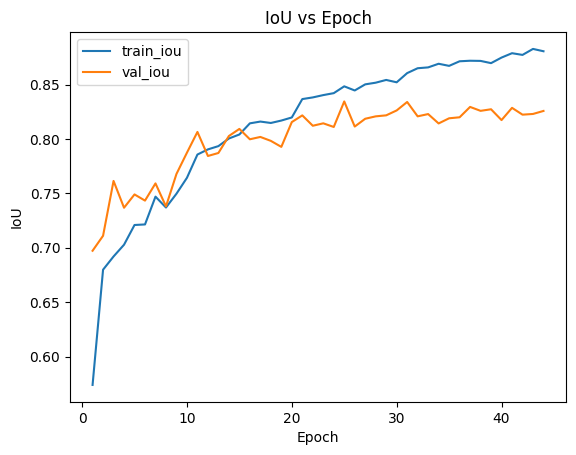

<Figure size 640x480 with 0 Axes>

In [ ]:

import pandas as pd

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
H = {"train_loss": [], "train_iou": [], "val_loss": [],"val_iou": [], "dice_score": [], "accuracy": [], "sensitivity": [], "specificity": []}

#totalTrainLoss = 0
#totalTestLoss = 0

def main():

    model = UNetAFF(3,2,bilinear=False)

    print('\nmoving models to GPU ...')
    ##model = torch.nn.DataParallel(model).cuda()
    model.cuda()
    criterion.to(DEVICE)
    print('done\n')


    #optimizer = torch.optim.RMSprop(model.parameters(), lr=2.0e-4, alpha=0.99, eps=1e-8, momentum=0, weight_decay=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4, weight_decay=0)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    print("[INFO] training the network...")

    startTime = time.time()

    best_iou = 0
    trigger = 0
    patience = 20

    for e in tqdm(range(NUM_EPOCHS)):
	  # set the model in training mode
          train_loss, train_iou, train_iou_Deno = train_function(trainLoader, model, criterion, optimizer)
          totalValLoss, val_iou, val_dice, val_accuracy,val_sensitivity,val_specificity, val_sen_Deno, val_spc_Deno,val_iou_Deno, val_dice_Deno = val_function(testLoader, model, criterion, optimizer)
          scheduler.step()

	# calculate the average training and validation loss
          avgTrainLoss = train_loss / trainSteps
          avgTrainIoU = train_iou/ train_iou_Deno

          avgValLoss = totalValLoss / testSteps
          avgValIoU = val_iou / val_iou_Deno
          avgValDice = val_dice/ val_dice_Deno
          avgValAcc = val_accuracy/ (len(testDS)*(240*240))
          avgValSen = val_sensitivity/ val_sen_Deno
          avgValSpe = val_specificity/ val_spc_Deno

          print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
          print("Train loss: {:.4f}, Val loss: {:.4f}, Train_iou: {:.4f}, Val_iou: {:.4f}".format(avgTrainLoss, avgValLoss, avgTrainIoU,avgValIoU))
          print("Dice Score: {:.4f}, Accuracy: {:.4f}, Sensitivity: {:.4f}, Specificity: {:.4f}".format(avgValDice,avgValAcc,avgValSen,avgValSpe))

          if avgValIoU > best_iou:

             torch.save(model.state_dict(),'/content/gdrive/MyDrive/Phd work/UNet++/UA_AHF_UNet.pth')
             best_iou=avgValIoU
             print("saved best model based on IOU: ", best_iou )
             trigger = 0
          else:
             trigger += 1
             print(f'EarlyStopping counter: {trigger} out of {patience}')

          if trigger >= patience:
                  print("Early stopping triggered")
                  break

	# update our training history
          if (e%1==0):
              H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
              H["train_iou"].append(avgTrainIoU)
              H["val_loss"].append(avgValLoss.cpu().detach().numpy())
              H["val_iou"].append(avgValIoU)
              H["dice_score"].append(avgValDice)
              H["accuracy"].append(avgValAcc)
              H["sensitivity"].append(avgValSen)
              H["specificity"].append(avgValSpe)


    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

    df = pd.DataFrame(H)

    df.to_csv('/content/gdrive/MyDrive/Phd work/Paper_Results/UA_AHF_UNet.csv', index=False)


    epochs_range = range(1, len(H['train_iou'])+1)

    plt.plot(epochs_range, H['train_iou'], label='train_iou')
    plt.plot(epochs_range, H['val_iou'], label='val_iou')
    plt.title('IoU vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()
    plt.tight_layout()
    time.sleep(4)


    torch.cuda.empty_cache()


def train_function(trainLoader, model, criterion, optimizer):
          model.train()
          totalTrainLoss = 0
          train_iou = 0
          train_iou_Deno = 0

	 # loop over the training set
          for (i, (x, y)) in enumerate(trainLoader):
	 # send the input to the device
              (x, y) = (x.to(DEVICE), y.to(DEVICE))
              #torch.cuda.empty_cache()
              #gc.collect()
              output = model(x) #output is the raw output from the model

              output1=torch.einsum('ijkl->iklj', [output])
              output1 = output1.reshape(-1,2)

              y1=torch.einsum('ijkl->iklj', [y])
              y1 = y1.reshape(-1,1)

              y1 = one_hot_embedding(y1.int(), num_classes=2,device=DEVICE).squeeze(1)

              loss_S = criterion(output1, y1)

              loss_U = edl_digamma_loss(output1, y1.float(), 1,2, 10, device=DEVICE)
              #loss = edl_mse_loss(output1, y1.float(), 1,2, 10, device=DEVICE)

              loss = loss_U + loss_S
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              totalTrainLoss += loss
              #pred = output.argmax(dim=1)
              iou, dice, accuracy, sensitivity, specificity,true_positives, false_positives,\
               false_negatives,true_negatives = evaluation_metrices(torch.argmax(output,dim=1).unsqueeze(1),y)
              train_iou += iou
              train_iou_Deno += true_positives + false_positives + false_negatives
          return totalTrainLoss, train_iou, train_iou_Deno

def val_function(testLoader, model, criterion, optimizer):
       totalValLoss = 0
       val_iou = 0
       val_dice = 0
       val_accuracy = 0
       val_sensitivity = 0
       val_specificity = 0
       val_sen_Deno = 0
       val_spc_Deno = 0
       val_iou_Deno = 0
       val_dice_Deno = 0

       with torch.no_grad():

              model.eval() # set the model in evaluation mode

              for (x,y) in testLoader:
                  (x, y) = (x.to(DEVICE), y.to(DEVICE))
                  output = model(x)
                  output1=torch.einsum('ijkl->iklj', [output])
                  output1 = output1.reshape(-1,2)
                  y1=torch.einsum('ijkl->iklj', [y])
                  y1 = y1.reshape(-1,1)
                  y1 = one_hot_embedding(y1.int(), num_classes=2,device=DEVICE).squeeze(1)
                  loss_S = criterion(output1, y1)
                  loss_U =edl_digamma_loss(output1, y1.float(), 1,2, 10, device=DEVICE)
                  #loss = edl_mse_loss(output1, y1.float(), 1,2, 10, device=DEVICE)

                  loss =loss_U + loss_S
                  #output=torch.argmax(output,dim=1).unsqueeze(1).float()
                  #ValLoss = criterion(output, y)
                  totalValLoss += loss
                  iou, dice, accuracy, sensitivity, specificity, true_positives,false_positives, false_negatives, \
                  true_negatives = evaluation_metrices(torch.argmax(output,dim=1).unsqueeze(1),y)

                  val_iou += iou
                  val_dice += dice
                  val_accuracy +=accuracy
                  val_sensitivity += sensitivity
                  val_specificity += specificity
                  val_sen_Deno += true_positives + false_negatives
                  val_spc_Deno += true_negatives + false_positives
                  val_iou_Deno += true_positives + false_positives + false_negatives
                  val_dice_Deno += 2*true_positives + false_positives + false_negatives
              return totalValLoss, val_iou, val_dice, val_accuracy,val_sensitivity, val_specificity, val_sen_Deno, val_spc_Deno, val_iou_Deno, val_dice_Deno


if __name__ == "__main__":

    main()


In [ ]:
# for evaluation purpose

# IMAGE_DATASET_PATH_E = '/content/gdrive/MyDrive/Phd work/UNet++/Eva_Image/'
# MASK_DATASET_PATH_E = '/content/gdrive/MyDrive/Phd work/UNet++/Eva_mask/'
IMAGE_DATASET_PATH_E = '/content/gdrive/MyDrive/Phd work/ISIC 2017/New_Eva_17/'
MASK_DATASET_PATH_E = '/content/gdrive/MyDrive/Phd work/ISIC 2017/New_Mask_Eva_17/'

imagePaths_E = sorted(list(paths.list_images(IMAGE_DATASET_PATH_E)))
maskPaths_E = sorted(list(paths.list_images(MASK_DATASET_PATH_E)))

trainDS_E = SegmentationDataset(imagePaths=imagePaths_E, maskPaths=maskPaths_E,transforms=transforms)

print(f"[INFO] found {len(trainDS_E)} examples in the training set...")

trainLoader_E = DataLoader(trainDS_E, shuffle=False, batch_size= 5, num_workers=os.cpu_count())

[INFO] found 5 examples in the training set...


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

<ipython-input-22-44fb6436936b>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/Phd work/UNet++/UA_AHF_UNet.pth')

torch.Size([5, 1, 240, 240])
output B:  torch.Size([5, 240, 240])
output A:  (5, 240, 240)


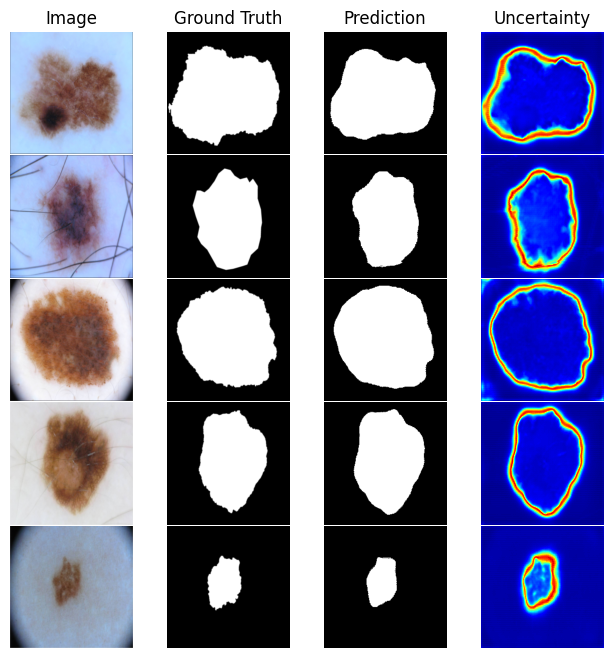

In [ ]:
#FOR ORIGINAL F_UQ_AFF
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt



#dir_name = '/content/gdrive/MyDrive/Phd work/Paper_Results/Evaluation_image/UA_ISIC/'

#For new work


# Load a sample image and mask pair from trainLoader
for image, mask in trainLoader_E:
    break

#model = UNet()
model = UNetAFF(3,2,bilinear=False)

model.load_state_dict(torch.load('/content/gdrive/MyDrive/Phd work/UNet++/UA_AHF_UNet.pth'))

with torch.no_grad():
    output = model(image)

evidence = F.relu(output)
alpha = evidence + 1


S = torch.sum(alpha, dim=1, keepdim=True)
print(S.shape)
print("output B: ", output[:,1,:,:].shape)
# output = output.squeeze(1).cpu().numpy()
output = torch.argmax(output,dim=1).cpu().numpy()
print("output A: ", output.shape)

output = output > 0.5

# Plot the image, mask, and segmented result
fig, ax = plt.subplots(5, 4, figsize=(8, 8)) #, gridspec_kw={'width_ratios': [1, 1, 1]})
for i in range(5):
    if i==0:
      ax[i][0].set_title('Image')
      ax[i][1].set_title('Ground Truth')
      ax[i][2].set_title('Prediction')
      ax[i][3].set_title('Uncertainty')

    ax[i][0].imshow(image[i].squeeze().permute(1, 2, 0))
    ax[i][1].imshow(mask[i].squeeze(), cmap='gray')
    ax[i][2].imshow(output[i], cmap='gray')
    ax[i][3].imshow(2/S[i].squeeze(), cmap='jet')



    fig.subplots_adjust(wspace=0.05,hspace=0.01)

    # saving files for all images
    # flattened_image = image[i].permute(1, 2, 0).reshape(-1, 3).numpy()
    # img_df = pd.DataFrame(flattened_image)
    # mask_df = pd.DataFrame(mask[i].numpy().squeeze(0))
    # out_df = pd.DataFrame(output[i])
    # uq_df = pd.DataFrame(2/S[i].squeeze(0))

    # img_df.to_csv(os.path.join(dir_name,f'img{i}.csv'),index=False)
    # mask_df.to_csv(os.path.join(dir_name, f'mask{i}.csv'),index=False)
    # out_df.to_csv(os.path.join(dir_name,f'output{i}.csv'),index=False)
    # uq_df.to_csv(os.path.join(dir_name,f'uq{i}.csv'),index=False)

    for a in ax[i]:
        a.axis('off')

plt.show()

